# Energy A.I. Hackathon 2023 - Project Template 

## General Guidance

We're expecting a workflow that could be deployed to any competent engineer or scientist with basic subsurface resource, data analytics and machine learning knowledge and they could understand and apply your workflow. 

### Expectations on the Workflow

* include short descriptions, no 2 code blocks should be adjacent, always have a short statement to explain the next code block

* be as concise as possible:

    * use point form (except for the executive summary) 
    * use effective, creative figures that compine what could have been in multiple plots
    * every line of code, statment or figure must have purpose
    * conciseness is part of the grading, don't add content that isn't needed
    
* be very clear with readable code

    * label every axis for every plot
    * use readable code, logical variable names, use available functionality and define functions and classes for compactness and concise comments in the code
    * proceed step by step, explain each important step concisely for a easy to follow narrative 
    
  
### Using Code From Others
  
You may use blocks/snipets of code from other sources with citation. To cite a set of code separate in a block and do this in the markdown above the block.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).

```python
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
```

or use inline citations with comments, such as this for a few of lines of code.

```python
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean): # function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb 
```

## The Workflow Template

Here's the template for your workflow.

___

# Energy A.I. Hackathon 2023 Workflow - [Your Team Name] 

#### Authors: [Your Names],  [Your Departments and Schools] 

#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Only 4 short sentences.

1. What is the problem?
2. What did your team do to address the problem?
3. What did your team learn?
4. What does your team recommend going forward?

___

### Workflow Goal

1-2 sentences 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$

$\ldots$


### Import Packages

In [105]:
import numpy as np                                      # model arrays
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # building plots
import os                                               # accessing the operating system


import geostatspy.GSLIB as GSLIB                        # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                  # GSLIB methods convert to Python  

In [106]:
import numpy as np                                      # ndarrys for gridded data
import pandas as pd                                     # DataFrames for tabular data
import os                                               # set working directory, run executables
import matplotlib.pyplot as plt                         # for plotting
from matplotlib.colors import ListedColormap            # custom color maps
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from scipy import stats                                 # summary statistics
import math                                             # trigonometry etc.
import scipy.signal as signal                           # kernel for moving window calculation
import random                                           # for randon numbers
import seaborn as sns                                   # for matrix scatter plots
from scipy import linalg                                # for linear regression
from sklearn import preprocessing                       # remove encoding error
from sklearn.feature_selection import RFE               # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression # mutual information
from sklearn.linear_model import LinearRegression       # linear regression model
from sklearn.ensemble import RandomForestRegressor      # model-based feature importance
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
plt.rc('axes', axisbelow=True)                          # girds and axes behind all plot elements
cmap = plt.cm.inferno                                   # default colormap

In [107]:
def partial_corr(C):                                    # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                         # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                  # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):             # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):              # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):           # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):             # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')
    
    


### Load Data

The following workflow applies the .csv file '300well_MV.csv', a synthetic dataset calculated with geostatistical cosimulation by Wayne Gretzky, The Edmonton Oilers Hockey Team. The dataset is publically available [here](http://www.hasthelargehadroncolliderdestroyedtheworldyet.com/)  

We will work with the following features:

* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$

In [4]:
# os.chdir("c:/PGE383")                                   # set the working directory

my_data = pd.read_csv("dailyData.csv")                  # load the comma delimited data file
#my_data = my_data.iloc[:,1:]                           # copy all rows and columns 1 through 8, note 0 column is removed

In [114]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

my_data.head()

#How to tackle wells with long missing data





,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
0,615.154601,650.447788,526.488655,ESP,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
1,1224.193640,1232.455787,809.414685,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
2,1007.769762,1047.068544,667.933899,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
3,1514.641876,1370.143160,1122.137652,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
4,1089.741764,1387.138130,1156.169599,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345


In [14]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50056 entries, 0 to 50055
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   OIL                                             50052 non-null  float64
 1   GAS                                             50052 non-null  float64
 2   WATER                                           50052 non-null  float64
 3   ARTIFICIAL_LIFT                                 50052 non-null  object 
 4   DOWN_TIME_HOURS                                 50052 non-null  float64
 5   ESP Data - Drive Current                        40177 non-null  float64
 6   ESP Data - Drive Voltage                        41449 non-null  float64
 7   ESP Data - Intake Pressure                      39824 non-null  float64
 8   ESP Data - Motor Temperature Shutdown Setpoint  32397 non-null  float64
 9   ESP Data - Motor Winding Temperature   

In [16]:
my_data.describe()

,OIL,GAS,WATER,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,Well_ID
count,50052.000000,50052.000000,50052.000000,50052.000000,40177.000000,41449.000000,39824.000000,32397.000000,40078.000000,42369.000000,31332.000000,44351.000000,40121.000000,40125.000000,40099.000000,40125.000000,39950.000000,39950.000000,39949.000000,39950.000000,39950.000000,39950.000000,39825.000000,35540.000000,39949.000000,3.763200e+04,34724.000000,37016.000000,3.838700e+04,34722.000000,39832.000000,32078.000000,37183.000000,32954.000000,33869.000000,50056.000000
mean,586.684746,683.051091,803.821808,0.993900,256.673039,416.194779,1090.615958,460.818960,180.897056,56.586441,26.506865,61.292835,817.486359,848.394287,1187.558230,1666.387919,0.434924,0.550327,573.006969,620.794733,190.595178,510.571279,2157.887755,2773.811035,2064.270715,1.774602e-01,1698.024421,1890.881581,1.740643e-01,38.749969,108.073650,0.378877,80.128262,164.493709,1056.314033,137.772395
std,416.097647,357.946248,649.389332,3.962034,68.674683,50.572335,559.504784,724.402577,9.210206,5.244889,119.750461,319.460377,617.038008,665.318994,851.336575,1166.599610,0.251089,0.143359,339.588739,582.602258,122.465317,294.435353,603.285578,624.971879,1192.927162,3.215276e-01,651.538135,572.084984,2.259487e-01,23.685941,28.065324,0.184717,35.746098,6.391313,594.611931,113.120075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300.599873,0.000000,135.223159,5.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,701.675330,1000.017996,0.012324,0.000000e+00,3.998846,500.016481,0.000000e+00,0.065588,30.265603,0.000658,0.837517,145.950205,175.000000,0.000000
25%,294.586269,439.684454,351.194557,0.000000,226.351533,395.794169,768.650186,230.000000,174.604694,54.000000,0.000000,8.000000,396.841077,370.796333,489.540670,819.272073,0.231538,0.453275,316.071972,159.921985,104.373823,301.498440,1689.165486,2386.326396,1157.096688,1.110000e-16,1271.655861,1580.943809,1.110000e-16,21.245901,93.387680,0.243109,57.990861,161.844117,675.000000,50.000000
50%,482.662466,660.094888,604.544784,0.000000,259.103629,423.461516,919.291387,240.000000,180.036207,58.000000,0.017917,19.000000,630.087413,630.471145,1195.756077,1260.915773,0.503336,0.548580,629.639210,526.702012,187.475664,465.757675,2219.329907,2840.032372,1752.014767,2.220000e-16,1760.394227,1858.147862,5.710657e-02,33.807649,108.695271,0.358939,76.414622,165.621877,800.000000,102.000000
75%,785.061899,917.471681,1082.319580,0.000000,295.181748,443.312180,1196.165042,240.000000,186.310482,60.000000,0.400736,37.000000,1060.763678,1162.091885,1778.569858,2249.713278,0.637698,0.633840,831.946463,954.667943,271.642458,676.926805,2687.626434,3210.505444,2808.356901,1.895152e-01,2163.639322,2172.520632,3.033109e-01,51.563475,124.107305,0.499620,95.539242,168.748081,1450.000000,252.000000
max,3979.729266,3460.787784,7011.564091,24.000000,570.267352,487.500000,4519.367705,4460.000000,260.799988,69.000000,1288.456366,3466.000000,5330.747102,7168.816766,10325.627120,9933.143674,1.000000,1.000000,1870.891275,10142.015180,883.577593,3138.533966,3376.916650,5865.744030,10074.893710,1.000000e+00,4791.517048,4881.811307,1.000000e+00,191.143370,233.379053,0.999723,297.162058,199.201965,3550.000000,362.000000


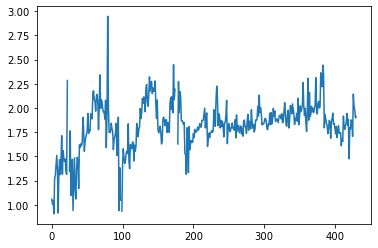

In [96]:
d = {}
for i in range (0,362):
    #my_data.loc[my_data["Well_ID"]==i]
    d["wellno{0}".format(i)]=my_data.loc[my_data["Well_ID"]==i]
    


plt.plot(d["wellno345"]["GAS"]/d["wellno345"]["OIL"])


#for i in range (0,362):
    

#df_wells=my_data["Well_ID"]





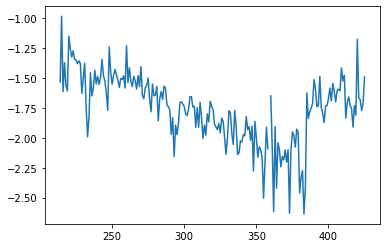

In [98]:
plt.plot(d["wellno345"]["Gas_Intake"]/d["wellno345"]["Oil_Intake"])


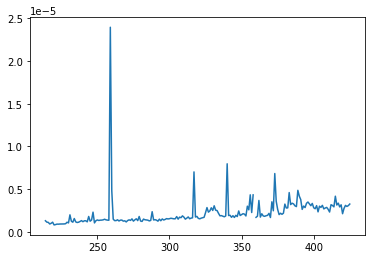

In [100]:
plt.plot(d["wellno345"]["GAS"]/d["wellno345"]["OIL"]-d["wellno345"]["Gas_Intake"]/d["wellno345"]["Oil_Intake"])


In [138]:
d["wellno345"].head()

,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
0,615.154601,650.447788,526.488655,ESP,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
1,1224.193640,1232.455787,809.414685,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
2,1007.769762,1047.068544,667.933899,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
3,1514.641876,1370.143160,1122.137652,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
4,1089.741764,1387.138130,1156.169599,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345


In [143]:
well_no_345=my_data.loc[my_data["Well_ID"]==345]
well_no_345.tail()

,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
426,310.534376,665.662373,387.024129,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
427,263.468895,531.043553,287.802970,ESP,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
428,257.310251,509.170566,336.918101,ESP,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
429,318.877302,605.508428,400.060895,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345
430,329.416360,629.020704,431.660834,ESP,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_2,345


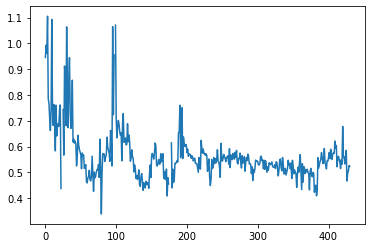

In [45]:
plt.plot(well_no_345["OIL"]/well_no_345["GAS"])

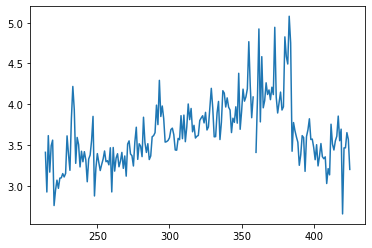

In [55]:
plt.plot(well_no_345["Gas_Intake"]/well_no_345["Oil_Intake"])

In [56]:
well_no_345.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431 entries, 0 to 430
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   OIL                                             431 non-null    float64
 1   GAS                                             431 non-null    float64
 2   WATER                                           431 non-null    float64
 3   ARTIFICIAL_LIFT                                 431 non-null    object 
 4   DOWN_TIME_HOURS                                 431 non-null    float64
 5   ESP Data - Drive Current                        211 non-null    float64
 6   ESP Data - Drive Voltage                        211 non-null    float64
 7   ESP Data - Intake Pressure                      211 non-null    float64
 8   ESP Data - Motor Temperature Shutdown Setpoint  0 non-null      float64
 9   ESP Data - Motor Winding Temperature       

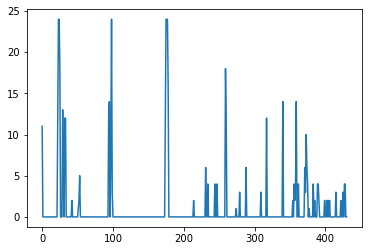

In [59]:
well_no_345["DOWN_TIME_HOURS"].sum()
plt.plot(well_no_345["DOWN_TIME_HOURS"])

In [13]:
static_df = pd.read_csv("wellData.csv")    

static_df.head()

# Count NaN for each feature
# Determine which features to remove strictly on this



,Unnamed: 0,Well_ID,AL_Key,Artificial_Lift_Type,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth,Failure_Type,Failure_Type_Detail
0,0,345,ESP_2,ESP,9056.67,0,5.323174,NaN,NaN,NaN,NaN,1.713554,ELECTRICAL,MOTOR
1,1,29,ESP_3,ESP,8982.09,0,6.440650,NaN,NaN,NaN,NaN,2.789395,PUMP,MOTOR
2,2,327,ESP_1,ESP,8876.37,0,5.669751,NaN,NaN,NaN,NaN,0.481680,ELECTRICAL,UNKNOWN
3,3,71,ESP_1,ESP,8930.11,0,5.614798,NaN,NaN,NaN,NaN,0.842038,ELECTRICAL,UNKNOWN
4,4,125,ESP_2,ESP,8616.41,348,26.061750,NaN,NaN,NaN,NaN,NaN,ELECTRICAL,PENETRATOR


In [17]:
static_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  166 non-null    int64  
 1   Well_ID                     166 non-null    int64  
 2   AL_Key                      166 non-null    object 
 3   Artificial_Lift_Type        166 non-null    object 
 4   AL_Bottom_Depth             166 non-null    float64
 5   ESP_Pump_Stages             166 non-null    int64  
 6   DLS_Critical                163 non-null    float64
 7   ESP_Motor_Frequency_Rating  10 non-null     float64
 8   ESP_Motor_Current_Rating    85 non-null     float64
 9   ESP_Motor_Voltage_Rating    85 non-null     float64
 10  ESP_Motor_Power_Rating      85 non-null     float64
 11  DLS_at_Set_Depth            67 non-null     float64
 12  Failure_Type                166 non-null    object 
 13  Failure_Type_Detail         165 non

In [18]:
static_df.describe()

,Unnamed: 0,Well_ID,AL_Bottom_Depth,ESP_Pump_Stages,DLS_Critical,ESP_Motor_Frequency_Rating,ESP_Motor_Current_Rating,ESP_Motor_Voltage_Rating,ESP_Motor_Power_Rating,DLS_at_Set_Depth
count,166.000000,166.000000,166.000000,166.000000,163.000000,10.0,85.000000,85.000000,85.000000,67.000000
mean,82.500000,130.584337,8077.384518,234.885542,17.250072,60.0,70.781176,2230.929412,227.922353,4.844286
std,48.064193,107.306085,785.601429,175.935264,6.332956,0.0,45.378206,838.594669,86.662526,17.647618
min,0.000000,0.000000,0.000000,0.000000,4.879671,60.0,18.000000,1055.000000,18.000000,0.092562
25%,41.250000,50.250000,7784.477500,0.000000,13.133512,60.0,67.100000,1393.000000,161.000000,0.321964
50%,82.500000,99.500000,8131.600000,267.000000,17.561921,60.0,67.100000,2626.000000,216.000000,0.682052
75%,123.750000,165.000000,8544.970000,415.000000,20.490922,60.0,75.000000,2626.000000,270.000000,2.266419
max,165.000000,362.000000,9056.670000,504.000000,36.113674,60.0,456.000000,4181.000000,456.000000,143.251918


In [20]:
solution_df = pd.read_csv('solution.csv')
solution_df.head()

,Well_ID,AL_Key,Fail in 30 days
0,327,ESP_1,0
1,125,ESP_2,1
2,260,ESP_3,0
3,21,ESP_1,1
4,16,ESP_1,0


### Functions

The following functions will be used in the workflow.

In [124]:
def plot_corr(dataframe,size=10):                       # plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

### Basic Data Checking and Visualization

Since our method relies on the assumption of pairwise correlation, we check the correlation matrix and confirm this. 

* the absolute pariwise correlations exceed 0.6 for por and logperm, por and AI, AI and TOC etc. 

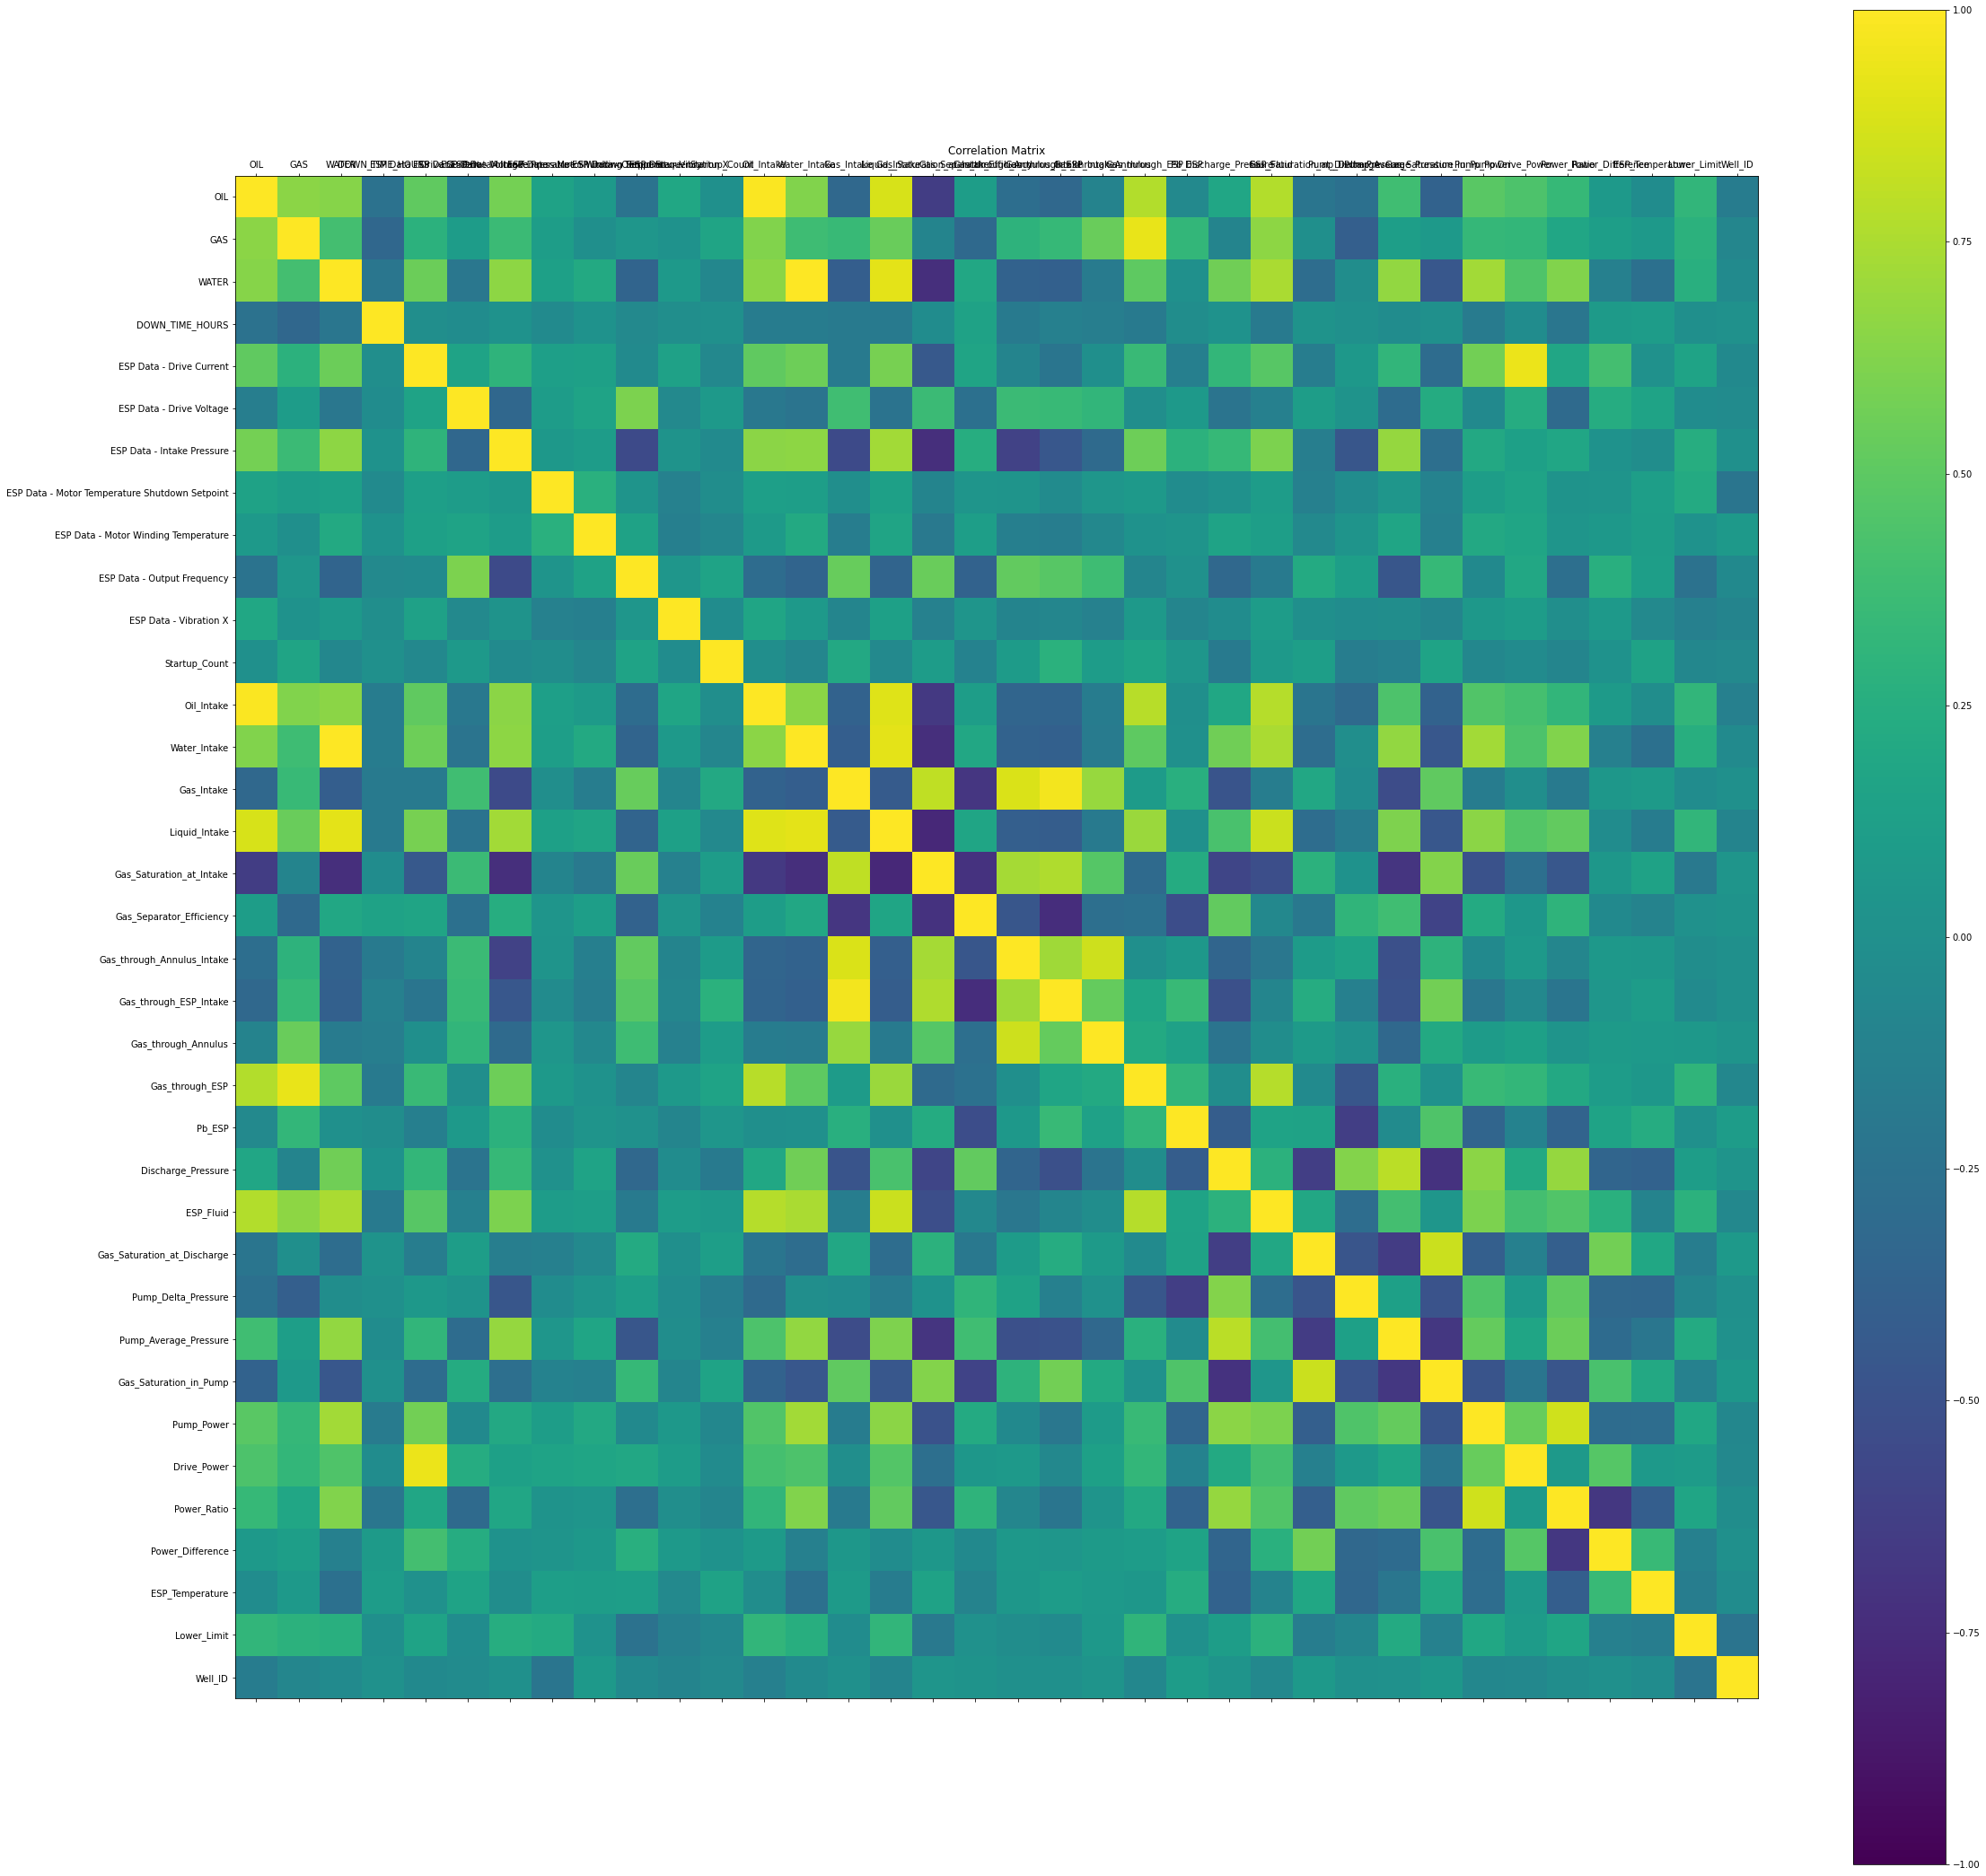

In [125]:
plot_corr(my_data,size = 38)

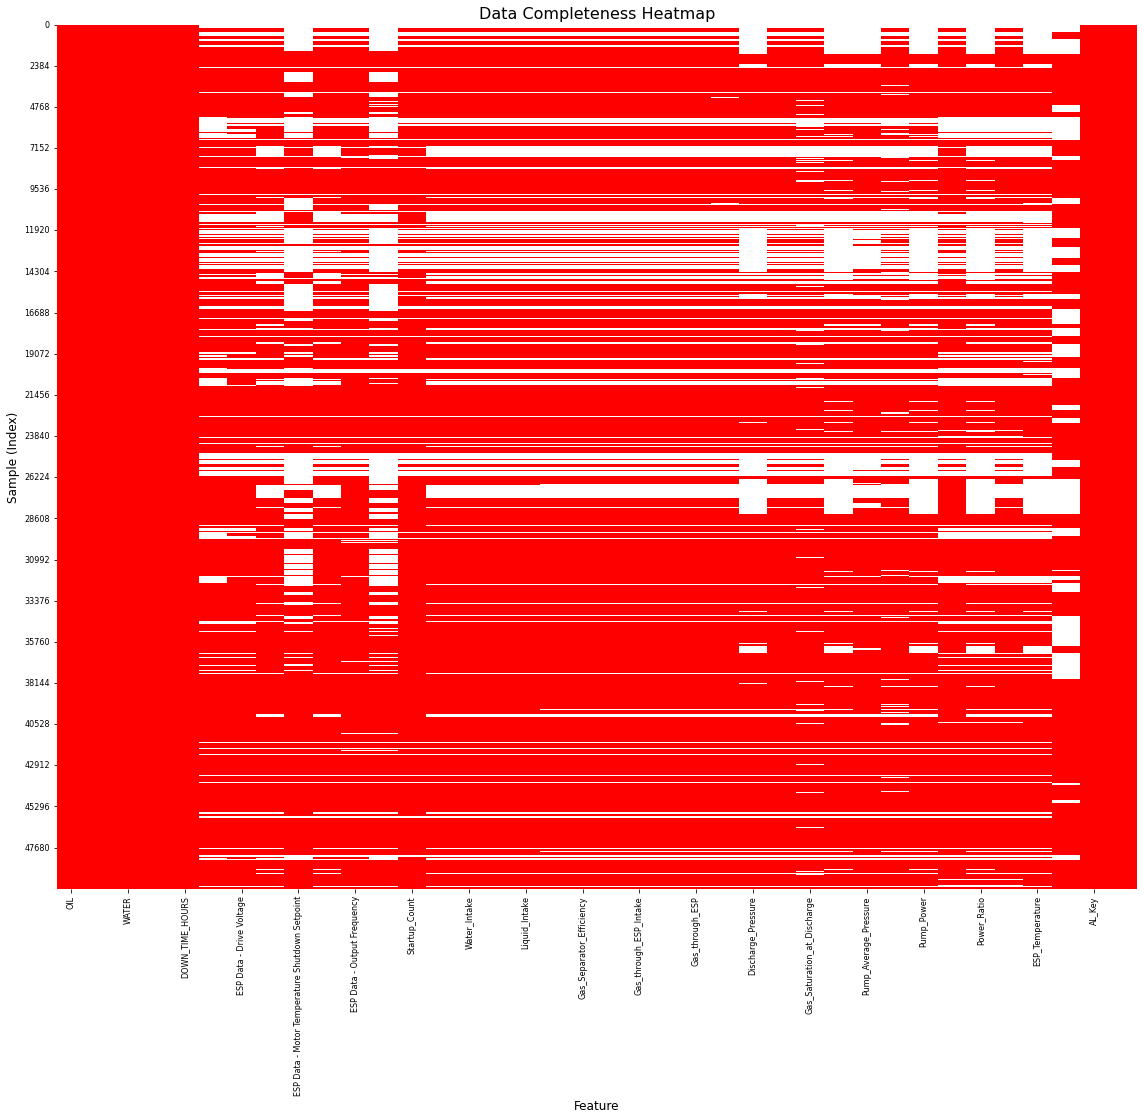

In [122]:
df_temp = my_data.copy(deep=True)                            # make a deep copy of the DataFrame

df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.001) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=3, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

(array([  6.,   6.,   6.,   6.,   6.,   6.,   6.,   7.,   7.,   8.,   8.,
          8.,  10.,  14.,  16.,  17.,  20.,  25.,  28.,  33.,  46.,  67.,
         84.,  86., 100., 107., 123., 136., 146., 161., 171., 186., 204.,
        217., 220., 231., 234., 241., 250., 264., 274., 282., 283., 286.,
        291., 299., 307., 314., 319., 320., 324., 327., 327., 327., 327.,
        329., 331., 339., 348., 351., 354., 358., 362., 367., 374., 381.,
        390., 395., 396., 397., 398., 401., 401., 401., 402., 403., 405.,
        407., 409., 411., 415., 416., 416., 417., 418., 419., 420., 422.,
        422., 424., 424., 424., 426., 427., 428., 430., 430., 430., 430.,
        431.]),
 array([   0.        ,   15.14641876,   30.29283752,   45.43925628,
          60.58567504,   75.7320938 ,   90.87851256,  106.02493132,
         121.17135008,  136.31776884,  151.4641876 ,  166.61060636,
         181.75702512,  196.90344388,  212.04986264,  227.1962814 ,
         242.34270016,  257.48911892,  272.635

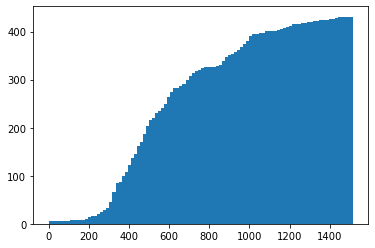

In [131]:
plt.hist(d["wellno345"]["OIL"],cumulative=True, bins=100)

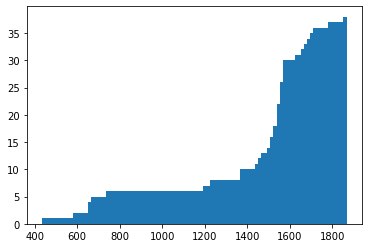

In [137]:
plt.hist(d["wellno20"]["OIL"],cumulative=True, bins=100);

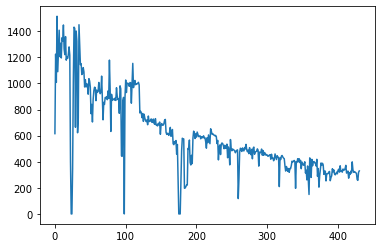

In [140]:
plt.plot(d["wellno345"]["OIL"])

In [ ]:
#cleaned2.reset_index(drop=True,inplace=True)

C:\Users\Richard\AppData\Local\Temp\ipykernel_19864\3100790365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["wellno345"]["cum_oil"]=d["wellno345"]["OIL"].cumsum(axis = 0);


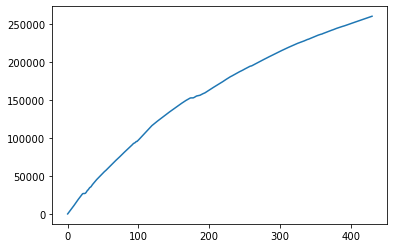

In [158]:
c=0
d["wellno345"]["cum_oil"]=d["wellno345"]["OIL"].cumsum(axis = 0);

plt.plot(d["wellno345"]["cum_oil"])



In [144]:
d["wellno21"]

,OIL,GAS,WATER,ARTIFICIAL_LIFT,DOWN_TIME_HOURS,ESP Data - Drive Current,ESP Data - Drive Voltage,ESP Data - Intake Pressure,ESP Data - Motor Temperature Shutdown Setpoint,ESP Data - Motor Winding Temperature,ESP Data - Output Frequency,ESP Data - Vibration X,Startup_Count,Oil_Intake,Water_Intake,Gas_Intake,Liquid_Intake,Gas_Saturation_at_Intake,Gas_Separator_Efficiency,Gas_through_Annulus_Intake,Gas_through_ESP_Intake,Gas_through_Annulus,Gas_through_ESP,Pb_ESP,Discharge_Pressure,ESP_Fluid,Gas_Saturation_at_Discharge,Pump_Delta_Pressure,Pump_Average_Pressure,Gas_Saturation_in_Pump,Pump_Power,Drive_Power,Power_Ratio,Power_Difference,ESP_Temperature,Lower_Limit,AL_Key,Well_ID
5899,145.075457,18.657113,10.309122,ESP,0.0,NaN,351.895609,3283.136803,NaN,192.855040,46.919415,NaN,1.000000,240.341174,10.524390,0.000000,250.865564,0.000000,0.995441,0.000000,0.000000,0.000000,18.657113,2870.080628,NaN,224.194376,2.080000e-17,NaN,2080.735844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5900,389.763705,227.747984,2173.364476,ESP,0.0,NaN,338.121857,3228.540972,NaN,186.749374,45.082914,NaN,2.000000,644.966771,2219.030119,0.000000,2863.996890,0.000000,0.748063,0.000000,0.000000,0.000000,227.747984,2870.080628,3378.566690,2864.622107,0.000000e+00,150.025719,3303.553831,0.000000e+00,4.728501,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5901,757.499676,435.055488,3938.692332,ESP,0.0,NaN,337.500000,3179.688063,NaN,186.138204,45.000000,NaN,2.000000,1252.178320,4021.903756,0.000000,5274.082076,0.000000,0.475422,0.000000,0.000000,0.000000,435.055488,2870.080628,3712.477148,5278.478474,NaN,532.789085,3446.082605,NaN,30.942437,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5902,753.205833,440.977871,3902.444685,ESP,0.0,NaN,337.500000,3148.640913,NaN,185.472409,45.000000,NaN,2.000000,1244.247460,3985.173421,0.000000,5229.420881,0.000000,0.479576,0.000000,0.000000,0.000000,440.977871,2870.080628,3700.158280,5234.015821,NaN,551.517367,3424.399597,NaN,31.760305,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5903,756.507642,53.067491,3742.829341,ESP,0.0,NaN,337.500000,3123.386420,NaN,185.123447,45.000000,NaN,2.000000,1249.016197,3822.393840,0.000000,5071.410037,0.000000,0.494579,0.000000,0.000000,0.000000,53.067491,2870.080628,3647.366405,5075.976029,1.110000e-16,523.979985,3385.376413,0.000000e+00,29.263395,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5904,600.637942,352.887579,3478.362351,ESP,0.0,NaN,337.458851,3128.250068,NaN,184.675550,44.994513,NaN,2.815470,991.775899,3552.265657,0.000000,4544.041557,0.000000,0.548078,0.000000,0.000000,0.000000,352.887579,2870.080628,3600.135823,4547.034308,0.000000e+00,471.885756,3364.192945,NaN,23.607801,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5905,720.738235,427.365793,3794.558447,ESP,0.0,NaN,337.500000,3104.619830,NaN,184.466093,45.000000,NaN,3.000000,1189.471552,3875.387131,0.000000,5064.858683,0.000000,0.495211,0.000000,0.000000,0.000000,427.365793,2870.080628,3612.469171,5068.984107,0.000000e+00,507.849341,3358.544500,0.000000e+00,28.323457,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5906,726.769571,423.804794,3814.011481,ESP,0.0,NaN,337.500000,3088.742425,NaN,184.400700,45.000000,NaN,3.000000,1199.006798,3895.393912,0.000000,5094.400710,0.000000,0.492366,0.000000,0.000000,0.000000,423.804794,2870.080628,3614.183963,5098.738187,NaN,525.441538,3351.463194,1.110000e-16,29.476611,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5907,731.321457,425.979240,3721.261498,ESP,0.0,NaN,337.500000,3075.302609,NaN,184.468280,45.000000,NaN,3.000000,1206.158400,3800.779579,0.000000,5006.937979,0.000000,0.500836,0.000000,0.000000,0.000000,425.979240,2870.080628,3581.340250,5011.250389,NaN,506.037641,3328.321429,NaN,27.900974,NaN,NaN,NaN,NaN,NaN,ESP_1,21
5908,703.289912,423.214161,3953.337730,ESP,0.0,NaN,337.500000,3062.568296,NaN,184.468337,45.000000,NaN,3.000000,1159.598964,4037.930092,0.000000,5197.529056,0.000000,0.482566,0.000000,0.000000,0.000000,423.214161,2870.080628,3676.329449,5202.253728,NaN,613.761153,3369.448873,1.110000e-16,35.130260,NaN,NaN,NaN,NaN,NaN,ESP_1,21


In [159]:
# Combine both well and daily data according to the specific well and pump
combined_data = pd.merge(static_df, my_data, on=["Well_ID", "AL_Key"])

In [162]:
# All wells in solution
solution_df = pd.read_csv("solution.csv")  # Read in solutions.csv
solution_ids = solution_df["Well_ID"].to_numpy()         # Get the Well_ID

In [163]:
# Creates a dataframe with only the data for the wells that haven't failed
solution_data = combined_data[combined_data["Well_ID"].isin(solution_ids)]

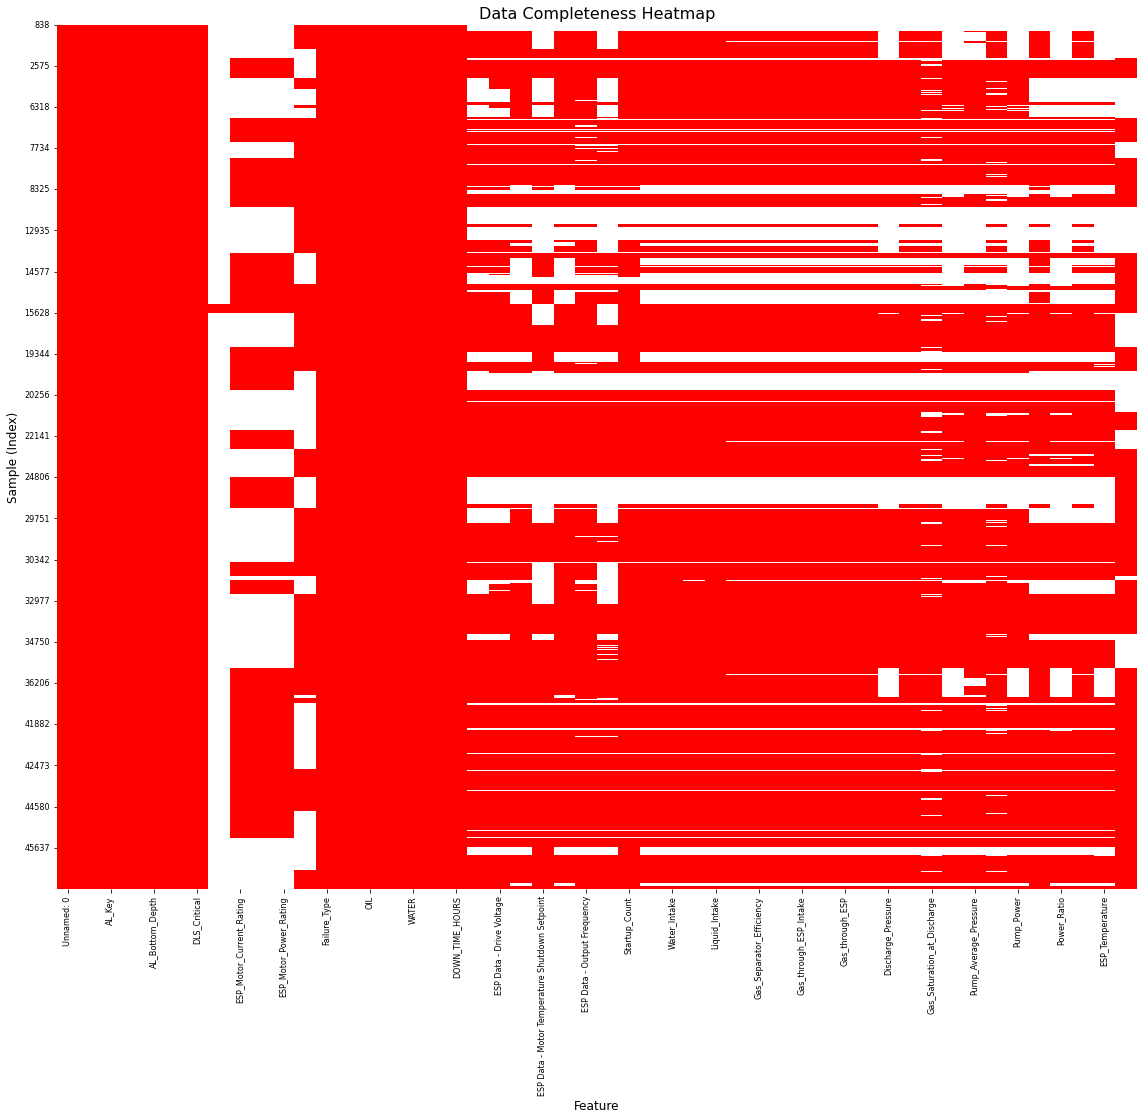

In [164]:
df_temp = solution_data.copy(deep=True)                            # make a deep copy of the DataFrame

df_bool = df_temp.isnull()                              # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))        # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.001) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
 
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=3, wspace=0.2, hspace=0.2) # plot formatting
plt.show()